In [29]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()


In [30]:
# now we will install and import xgboost for time series data forecasting
import xgboost as xgb

In [31]:
#let's read the data
df = pd.read_csv('PJME_hourly.csv')

In [32]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [33]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [34]:
#converting datetime column from string to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])
#setting datetime column as index
df = df.set_index('Datetime')

<AxesSubplot:title={'center':'PJME energy used in MW'}, xlabel='Datetime'>

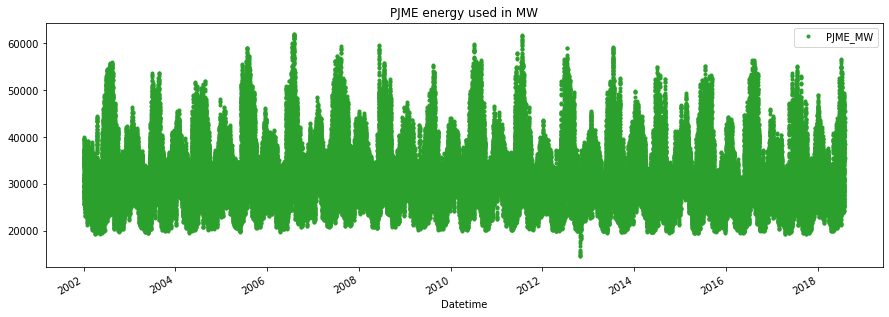

In [35]:
#let's try to plot our data for visualization
df.plot(style='.',figsize=(15,5),title= 'PJME energy used in MW',color = color_pal[2])

In [36]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [37]:
df.dtypes

PJME_MW    float64
dtype: object

In [38]:
# Train Test Splitting
# Remember we can't do random train test split here as we want to identify a trend here 
# Training data will contain past period information and test data should contain sequential data points
# Let's take training data of all datapoints present before 2015 and after 2015 all the data points will be used for testing
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

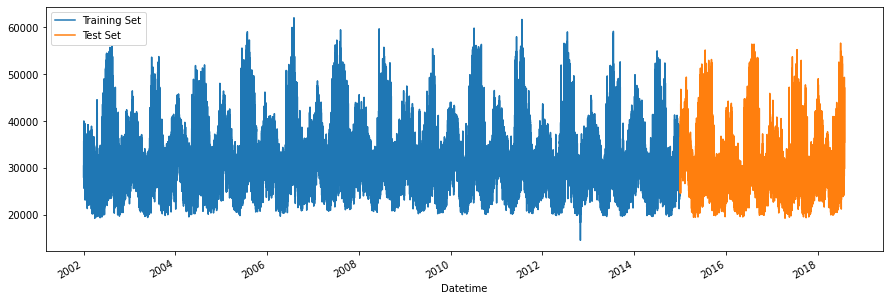

In [39]:
# Let's visualize training and testing split here
fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax , label = 'Training Data')
test.plot(ax=ax, label='Test data')
ax.legend(['Training Set','Test Set'])
plt.show()

<AxesSubplot:title={'center':'Aug first week trend'}, xlabel='Datetime'>

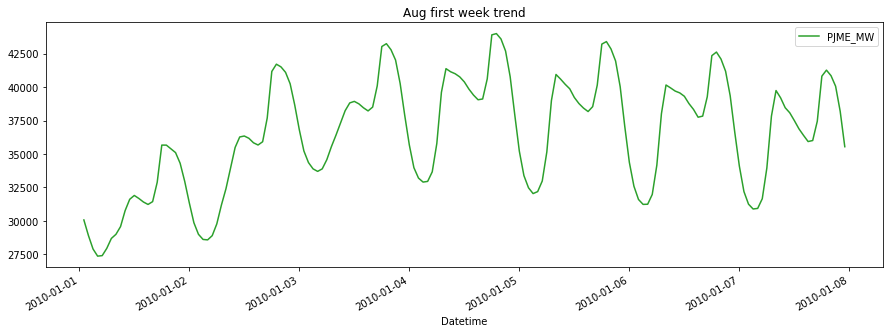

In [40]:
#if i want to check weekly trend , that's also possible here
aug_frst_wk = df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]
aug_frst_wk.plot(figsize=(15,5),title= 'Aug first week trend',color = color_pal[2])


In [41]:
# Let's also understand how we can split this data into more sub categories for better analysis
# Let's create features stating day , hour etc etc
def create_features(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day_of_week
    df['Quarter'] = df.index.quarter
    df['datcategory'] = df.index.weekday
    df['Month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df

In [44]:
df = create_features(df)

In [46]:
df.head()

,PJME_MW,hour,day,Quarter,datcategory,Month,year,dayofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,1,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,1,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,1,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,1,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,1,12,2002,365


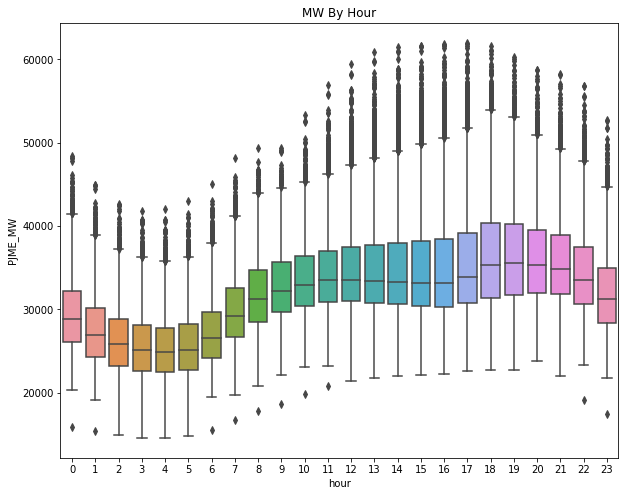

In [47]:
# Visualize the data
# Hourly
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df , x='hour', y = 'PJME_MW')
ax.set_title('MW By Hour')
plt.show()

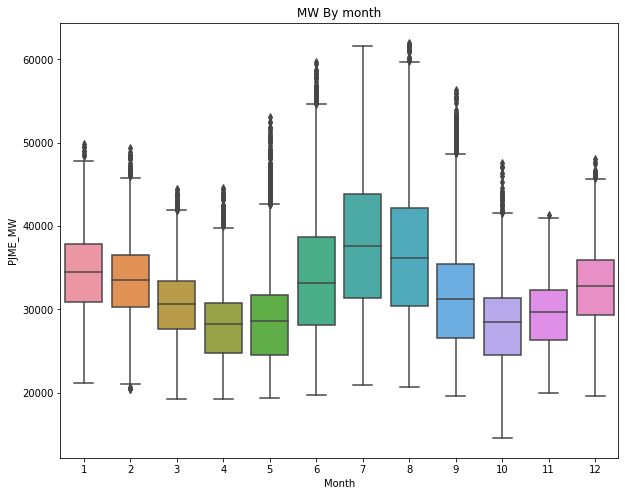

In [49]:
# Monthly
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df , x='Month', y = 'PJME_MW')
ax.set_title('MW By month')
plt.show()

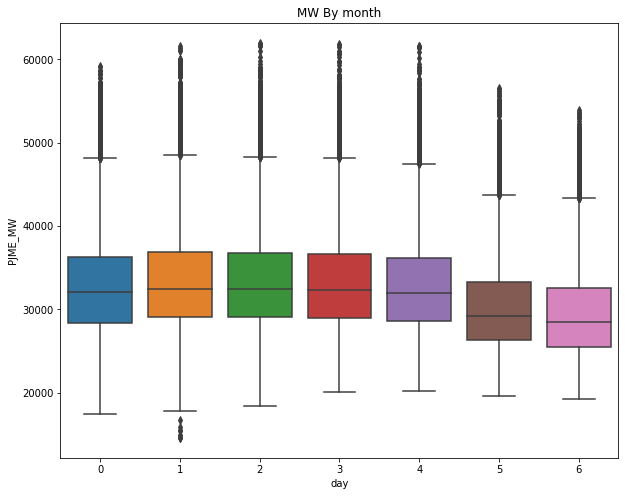

In [50]:
# Daily
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df , x='day', y = 'PJME_MW')
ax.set_title('MW By month')
plt.show()

In [51]:
#adding the new features into train and test set
train = create_features(train)
test = create_features(test)

C:\Users\sengu\AppData\Local\Temp\ipykernel_3692\239138633.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\sengu\AppData\Local\Temp\ipykernel_3692\239138633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day_of_week
C:\Users\sengu\AppData\Local\Temp\ipykernel_3692\239138633.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [53]:
# Feature and target separation
features = ['hour','day','Quarter','datcategory','Month','year','dayofyear']
target = ['PJME_MW']
xtrain = train[features]
ytrain = train[target]
xtest = test[features]
ytest = test[target]

In [60]:
# Model development
reg = xgb.XGBRegressor(n_estimators = 1000)
model = reg.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.5184036159428973

In [61]:
reg1 = xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds =50)
model2 = reg1.fit(xtrain,ytrain,eval_set=[(xtrain,ytrain),(xtest,ytest)])
model2.score(xtest,ytest)

[0]	validation_0-rmse:23192.08347	validation_1-rmse:22262.72116
[1]	validation_0-rmse:16420.93235	validation_1-rmse:15523.28748
[2]	validation_0-rmse:11738.22738	validation_1-rmse:10902.11140
[3]	validation_0-rmse:8540.54141	validation_1-rmse:7809.80731
[4]	validation_0-rmse:6406.33278	validation_1-rmse:5886.97003
[5]	validation_0-rmse:5020.18414	validation_1-rmse:4712.54530
[6]	validation_0-rmse:4115.48568	validation_1-rmse:4193.11193
[7]	validation_0-rmse:3582.20742	validation_1-rmse:3953.68877
[8]	validation_0-rmse:3261.69940	validation_1-rmse:3796.80086
[9]	validation_0-rmse:3081.02460	validation_1-rmse:3777.59061
[10]	validation_0-rmse:2982.98557	validation_1-rmse:3763.35259
[11]	validation_0-rmse:2888.50281	validation_1-rmse:3809.64469
[12]	validation_0-rmse:2840.45869	validation_1-rmse:3810.92832
[13]	validation_0-rmse:2794.92469	validation_1-rmse:3833.23047
[14]	validation_0-rmse:2768.03577	validation_1-rmse:3826.84933
[15]	validation_0-rmse:2747.60912	validation_1-rmse:3839.80

0.6595365615571771

In [63]:
reg2 = xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds =50,learning_rate=0.01)
model3 = reg2.fit(xtrain,ytrain,eval_set=[(xtrain,ytrain),(xtest,ytest)])
model3.score(xtest,ytest)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[1]	validation_0-rmse:32279.88735	validation_1-rmse:31332.60350
[2]	validation_0-rmse:31961.14360	validation_1-rmse:31014.27357
[3]	validation_0-rmse:31645.62525	validation_1-rmse:30699.10021
[4]	validation_0-rmse:31333.30788	validation_1-rmse:30385.92606
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.82644
[6]	validation_0-rmse:30718.10796	validation_1-rmse:29769.05547
[7]	validation_0-rmse:30415.17979	validation_1-rmse:29465.13991
[8]	validation_0-rmse:30115.31200	validation_1-rmse:29164.62813
[9]	validation_0-rmse:29818.48171	validation_1-rmse:28866.85195
[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.74321
[11]	validation_0-rmse:29233.82326	validation_1-rmse:28280.36822
[12]	validation_0-rmse:28945.84624	validation_1-rmse:27991.28725
[13]	validation_0-rmse:28660.79477	validation_1-rmse:27705.25177
[14]	validation_0-rmse:28378.63482	validation_1-rmse:27422.93837
[15]	validation_0-rmse:28099.33236	

0.6680627119684713